In [522]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

from PIL import Image
import os
import time
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

In [523]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [524]:
class FacadeDataset(Dataset):
    def __init__(self, base_path, transform=None):
        super().__init__()
        self.path_to_imgs = os.path.join(base_path, 'imgs')
        self.path_to_labels = os.path.join(base_path, 'labels')
        self.f_names = os.listdir(self.path_to_imgs)
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.path_to_imgs, self.f_names[idx])).convert('RGB')
        label = Image.open(os.path.join(self.path_to_labels, self.f_names[idx])).convert('RGB')

        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
        
        return img, label
    
    def __len__(self):
        return len(self.f_names)

In [525]:
BATCH_SIZE = 32

preprocessor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_path = os.path.join(os.getcwd(), 'data', 'facades', 'train')
dataset = FacadeDataset(train_path, preprocessor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [526]:
def calc_mean_std(loader: DataLoader):
   sum, sq_sum = 0, 0
   
   for data, _ in loader:
      sum += torch.mean(data, dim=[0, 2, 3])
      sq_sum += torch.mean(data ** 2, dim=[0, 2, 3])
   
   mean = sum / len(loader)
   std = (sq_sum / len(loader) - mean ** 2) ** .5
   
   return mean, std

mean, std = calc_mean_std(loader)

mean, std

(tensor([0.2080, 0.2071, 0.7184]), tensor([0.3701, 0.3221, 0.3740]))

In [527]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_path = os.path.join(os.getcwd(), 'data', 'facades', 'test')

train_ds = FacadeDataset(train_path, transform=transform)
test_ds = FacadeDataset(test_path, transform=transform)

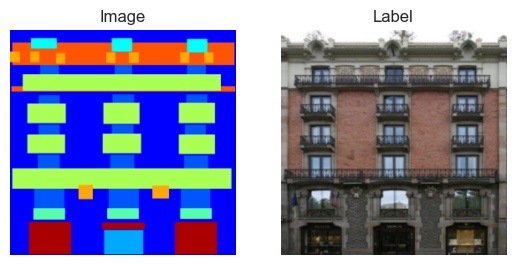

In [528]:
# Check sample
img, label = train_ds[0]

fig, axes = plt.subplots(1, 2)

img, label = img.clone(), label.clone()
img, label = to_pil_image(img * std.view(-1, 1, 1) + mean.view(-1, 1, 1)), to_pil_image(label * std.view(-1, 1, 1) + mean.view(-1, 1, 1))

axes[0].imshow(img)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(label)
axes[1].set_title('Label')
axes[1].axis('off')

plt.show()

In [529]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
test_loader = DataLoader(test_ds, BATCH_SIZE, generator=torch.Generator(device=device))

In [530]:
# Generator(Up)
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.):
        super().__init__()
        self.down = nn.Sequential()
        
        self.down.add_module('conv', nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False))
        
        if normalize:
            self.down.add_module('in', nn.InstanceNorm2d(out_channels))
        
        self.down.add_module('leaky_relu', nn.LeakyReLU(.2))

        if dropout:
            self.down.add_module('dropout', nn.Dropout(dropout))
        
    def forward(self, x):
        x = self.down(x)
        
        return x

In [531]:
# Generator(Down)
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.):
        super().__init__()
        self.up = nn.Sequential()
        
        self.up.add_module('conv_t', nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False))
        self.up.add_module('in', nn.InstanceNorm2d(out_channels))
        self.up.add_module('leaky_relu', nn.LeakyReLU())

        if dropout:
            self.up.add_module('dropout', nn.Dropout(dropout))
        
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)

        return x

In [532]:
# Generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=.5)
        self.down5 = UNetDown(512, 512, dropout=.5)
        self.down6 = UNetDown(512, 512, dropout=.5)
        self.down7 = UNetDown(512, 512, dropout=.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=.5)

        self.up1 = UNetUp(512, 512, dropout=.5)
        self.up2 = UNetUp(512 + 512, 512, dropout=.5)
        self.up3 = UNetUp(512 + 512, 512, dropout=.5)
        self.up4 = UNetUp(512 + 512, 512, dropout=.5)
        self.up5 = UNetUp(512 + 512, 256)
        self.up6 = UNetUp(256 + 256, 128)
        self.up7 = UNetUp(128 + 128, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 3, 4, 2, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.up8(u7)
        
        return u8

In [533]:
# Check
x = torch.randn(16, 3, 256, 256)
generator = Generator().to(device)
out = generator(x)

out.size()

torch.Size([16, 3, 256, 256])

In [534]:
generator

Generator(
  (down1): UNetDown(
    (down): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (down): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (in): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (down): Sequential(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (in): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (down): Sequential(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (in): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affi

In [535]:
# Discriminator's basic block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()
        self.block = nn.Sequential()
        
        self.block.add_module('conv', nn.Conv2d(in_channels, out_channels, 3, 2, 1))
        
        if normalize:
            self.block.add_module('in', nn.InstanceNorm2d(out_channels))
        
        self.block.add_module('leaky_relu', nn.LeakyReLU(.2))
        
    def forward(self, x):
        x = self.block(x)
        
        return x

In [536]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        
        self.stage_1 = BasicBlock(2 * in_channels, 64, normalize=False)
        self.stage_2 = BasicBlock(64, 128)
        self.stage_3 = BasicBlock(128, 256)
        self.stage_4 = BasicBlock(256, 512)
        
        self.patch = nn.Conv2d(512, 1, 3, padding=1) # 16 x 16
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, imgs, labels):
        x = torch.cat((imgs, labels), 1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = self.sigmoid(x)

        return x

In [537]:
discriminator = Discriminator().to(device)
out = discriminator(x, x)

out.size()

torch.Size([16, 1, 16, 16])

In [538]:
discriminator

Discriminator(
  (stage_1): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_2): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (in): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_3): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (in): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_4): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (in): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_

In [539]:
def init_params(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, a=.2, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            
generator.apply(init_params)
discriminator.apply(init_params)

Discriminator(
  (stage_1): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_2): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (in): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_3): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (in): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_4): BasicBlock(
    (block): Sequential(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (in): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_

In [540]:
# Training Settings
loss_gan = nn.BCELoss()
loss_l1 = nn.L1Loss()

weight_l1 = 100

patch = (1, 256 // 2**4, 256 // 2**4) # 16 x 16에 대하여 하나씩 참, 거짓 판별

lr = 2e-4
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(.5, .999))
opt_dis = optim.Adam(discriminator.parameters(), lr=lr, betas=(.5, .999))

In [541]:
# Training
generator.train()
discriminator.train()

epochs = 1_000
start_time = time.time()

loss_hist = {
    'gen': [],
    'dis': []
}

for epoch in range(epochs):
    for idx, (imgs, labels) in enumerate(train_loader):
        cur_batch_size = imgs.size(0)
        imgs, labels = imgs.to(device), labels.to(device)

        # Patch label
        reals = torch.ones(size=(cur_batch_size, *patch), requires_grad=False, device=device)
        fakes = torch.zeros(size=(cur_batch_size, *patch), requires_grad=False, device=device)

        # Generator
        generator.zero_grad()
        
        fake_labels = generator(imgs)
        pred_labels = discriminator(fake_labels, labels)
        
        gan_loss = loss_gan(pred_labels, reals)
        l1_loss = loss_l1(fake_labels, labels)
        
        g_loss = gan_loss + weight_l1 * l1_loss
        g_loss.backward()
        opt_gen.step()

        # Discriminator
        discriminator.zero_grad()
        
        pred_labels = discriminator(imgs, labels)
        real_loss = loss_gan(pred_labels, reals)

        pred_labels = discriminator(imgs, fake_labels.detach())
        fake_loss = loss_gan(pred_labels, fakes)
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        opt_dis.step()
        
        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        print(f"Epoch: {epoch + 1}, Step: {idx + 1}/{cur_batch_size} G_Loss: {g_loss.item():.6f}, D_loss: {d_loss.item():.6f}, time: {(time.time() - start_time) / 60:.2f} min")

Epoch: 1, Step: 1/32 G_Loss: 93.056709, D_loss: 0.795153, time: 0.28 min
Epoch: 1, Step: 2/32 G_Loss: 87.536201, D_loss: 0.767667, time: 0.50 min
Epoch: 1, Step: 3/32 G_Loss: 84.903214, D_loss: 0.722541, time: 0.71 min
Epoch: 1, Step: 4/32 G_Loss: 83.425926, D_loss: 0.700317, time: 0.93 min
Epoch: 1, Step: 5/32 G_Loss: 80.168594, D_loss: 0.691899, time: 1.14 min
Epoch: 1, Step: 6/32 G_Loss: 75.667671, D_loss: 0.666107, time: 1.35 min
Epoch: 1, Step: 7/32 G_Loss: 75.696495, D_loss: 0.659448, time: 1.57 min
Epoch: 1, Step: 8/32 G_Loss: 75.879417, D_loss: 0.633059, time: 1.79 min
Epoch: 1, Step: 9/32 G_Loss: 71.670898, D_loss: 0.636506, time: 2.00 min
